# A Plot of $k_{obs}$ vs. $\%H_2SO_4$ or $H_0$

This code will create the figure 2 in the discussion that plots $k_{obs}$ vs. $\% H_2SO_4$ and $\log{k_{obs}}$ vs $0.62H_0$ 

In [128]:
##############################################################
### Set up libraries and global variables
##############################################################

import interpolators   ### import the following functions from local library
# interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byMoleFraction()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()

import pandas as pd
pd.options.mode.chained_assignment = None    # no warning message and no exception is raised

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar


from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method. Returns smoothed x,y points
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method. Returns an interpolation function.
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method. Returns an interpolation function.
from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.

from matplotlib.patches import PathPatch
from matplotlib.path import Path


#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
github_H0_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_08/data/H0_data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.08
molwtH2O = 18.0
densityH2SO4 = 1.83
densityH2O = 1.000


In [129]:
##############################################################
### DATAFRAME for ESTER HYDROLYSIS KINETIC DATA
##############################################################

##############################################################
### Import the data and perform calculations
##############################################################

Data_File_Name = "Yates_Table1.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 
#display(df)

df1 = (df.loc[df['Ester'] == 'MeOAc'])   ### Select only the MeOAc data
df1 = (df.loc[0:7])   ### Select only the MeOAc data

##############################################################
### Perform calculations
##############################################################

df1["kobs"] = df1["kobs"] * 1E-2 * 60    # convert from 10^-2 min^-1 to s^-1
#df1["kobs"] = df1["kobs"]

PercentH2SO4 = df1["%H2SO4"]
molesH2SO4 = PercentH2SO4 / molwtH2SO4
PercentH2O = 100 - PercentH2SO4
molesH2O = PercentH2O / molwtH2O
total_moles = molesH2SO4 + molesH2O
mole_fraction_H2SO4 = molesH2SO4 / total_moles

df1["X_H2SO4"] = mole_fraction_H2SO4

interpolatorH0 = interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
df1["H0"] = interpolatorH0(PercentH2SO4)

m = 0.62
df1["HS"] = df1["H0"] * m

df1["log_k_obs"] = np.log10(df1["kobs"])

interpolator_aH2O = interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
df1["aH2O"] = interpolator_aH2O(PercentH2SO4)

interpolator_density = interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()
density = interpolator_density(PercentH2SO4)

volume = 1000
gramsH2O = volume * density * PercentH2O/100
molesH2O = gramsH2O / molwtH2O    # per liter

df1["Molar_H2O"] = molesH2O
df1["Molar_aH2O"] = df1["aH2O"]/(1-df1["X_H2SO4"])*df1["Molar_H2O"]

display(df1)

,Ester,%H2SO4,kobs,X_H2SO4,H0,HS,log_k_obs,aH2O,Molar_H2O,Molar_aH2O
0,MeOAc,14.1,0.900,0.029243,-0.597414,-0.370397,-0.045757,0.929987,52.275952,50.080484
1,MeOAc,20.7,1.566,0.045716,-1.040195,-0.644921,0.194792,0.873649,50.434878,46.173255
2,MeOAc,28.3,2.532,0.067544,-1.509841,-0.936101,0.403464,0.778187,47.988050,40.048746
3,MeOAc,34.8,3.846,0.089215,-2.000013,-1.240008,0.585009,0.669057,45.575514,33.479526
4,MeOAc,40.4,4.884,0.110638,-2.419997,-1.500398,0.688776,0.556795,43.253469,27.079348
5,MeOAc,45.4,6.240,0.132397,-2.794364,-1.732506,0.795185,0.449615,40.989529,21.241846
6,MeOAc,50.2,6.840,0.156117,-3.232965,-2.004438,0.835056,0.346623,38.651768,15.876097
7,MeOAc,55.2,7.980,0.184424,-3.780673,-2.344017,0.902003,0.246010,36.023445,10.866097


LinregressResult(slope=1.548896937806167, intercept=1.4388060880107192, rvalue=0.9988084141545353, pvalue=4.2259836304534895e-09, stderr=0.030896761185880604, intercept_stderr=0.04488204886300687)


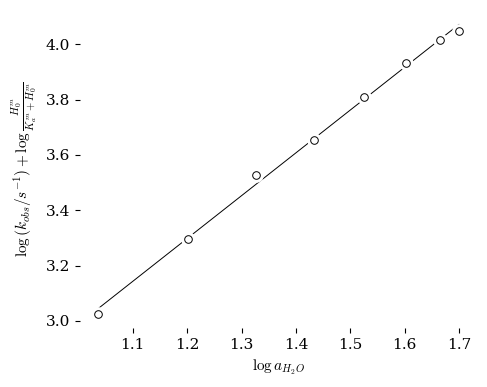

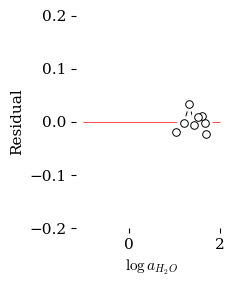

In [130]:
###################################################
### MAKE PLOT
###################################################

pKa = -7.2
Ka = 10**-pKa

h_0 = 10**-df1["H0"]

m = 0.62

###################################################
### Select the data for ESTER HYDROLYSIS
###################################################

#x = np.log10(df1["aH2O"])
x = np.log10(df1["Molar_aH2O"])



#y = df1["log_k_obs"]
#y = df1["log_k_obs"]-np.log10(h_0**m)
y = df1["log_k_obs"]-np.log10(h_0**m/(Ka**m + h_0**m))

#y = df1["log_k_obs"] + m * df1["H0"]




###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

#x_label = "$\%wt {H_2SO_4}$"
x_label = "$\log{a_{H_2O}}$"

y_label = "$\log{(k_{obs} / {s}^{-1})} + \log\\frac{H_0^m}{K_a^m+H_0^m}$"

###################################################
### RATE vs ACIDITY Plot
###################################################

if True:                  # Set up axes for main plot
    ax.set(ylabel=y_label, xlabel=x_label,
#           xlim=[0,-5],
#           ylim=[0,-5]
           )

if True:                       # Data points for kobs vs Acidity
    ax.scatter(x, y, 
              marker = "o", s = 30, 
              color = "white", edgecolors = "black", linewidths=0.7, 
              zorder = 2)
    ax.scatter(x, y,           # White circle behind each data point 
              marker = "o", s = 90, 
              color = "white", 
              zorder = 1)


a = linregress(x,y)
print(a)
y_line = a.slope * x + a.intercept

ax.plot(x, y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 0)

plt.savefig("fig4.pdf")
plt.show()


#print(np.log(df1["Molar_aH2O"]))






###################################################
### Create figure for RESIDUAL plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  

###################################################
### Set up labels
###################################################

#x_label = "$\%wt {H_2SO_4}$"
x_label = "$\log{a_{H_2O}}$"

y_label = "Residual"

###################################################
### Plot the residuals
###################################################

ax.set(ylabel=y_label, xlabel=x_label,
#           xlim=[0,-5],
           ylim=[-.2,.2]
        )

ax.plot(x, y-y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 0)

ax.scatter(x, y-y_line, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
ax.scatter(x, y-y_line,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 1)

#ax.hlines(0,np.min(x),np.max(x), color ="red", linewidths =0.5, zorder=0)
ax.hlines(0,-1,2, color ="red", linewidths =0.5, zorder=0)

plt.savefig("fig4r.pdf")
plt.show()


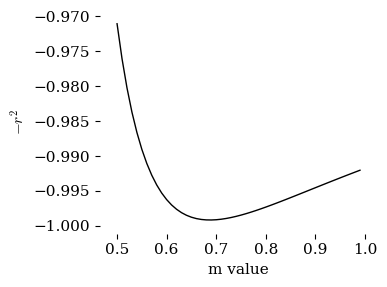

The optimal value for r is 0.687 for rsq = -0.99916


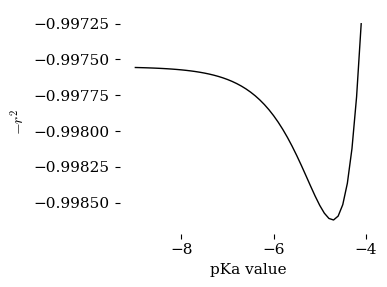

The optimal value for r is -4.717 for rsq = -0.99862
The optimal value for m is -5.891 and for pka is 0.680 for rsq = -0.99916


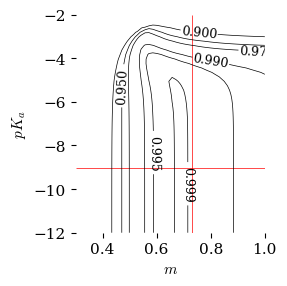

In [131]:
###################################################
### CURVE FIT FOR PARAMETERS
###################################################

# Try to curve fit for m, pKa and maybe n


def RSQ_function(m):    # returns the RSQ for linefits using the given Yukawa-Tsuno r factor
    pKa = -7.2
    Ka=10**-pKa
    h_0 = 10**-df1["H0"]
    x = np.log10(df1["Molar_aH2O"]) 
#    y = df1["log_k_obs"]+ m * df1["H0"]
    y = df1["log_k_obs"]- np.log10(h_0**m/(Ka**m + h_0**m))
    linfit = linregress(x,y)
    return -(linfit.rvalue**2)

def RSQ_function2(pKa):    # returns the RSQ for linefits using the given Yukawa-Tsuno r factor
    m = 0.62
    h_0 = 10**-df1["H0"]
    Ka = 10**-pKa
    x = np.log10(df1["Molar_aH2O"]) 
    y = df1["log_k_obs"]- np.log10(h_0**m/(Ka**m + h_0**m))
    linfit = linregress(x,y)
    return -(linfit.rvalue**2)


##########################################################
### Plot the value of -RSQ as the value of r is varied ###
##################################################

style_file = "tufte.mplstyle"
#style_file = "S2_classic2.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
ax.set(ylabel=r"$-r^2$", 
       xlabel=r"m value")

rsq_range=[]
r_range = np.arange(0.5,1,0.01)
for r in r_range:
    rsq = RSQ_function(r)
    rsq_range.append(rsq)
    
ax.plot(r_range,rsq_range)

#fig.savefig("plot.pdf")   # use this to save the figure in PDF format
plt.show()

##################################################
### Determine optimal r value to minimize -RSQ ###
##################################################

r_opt = minimize_scalar(RSQ_function)
print(f"The optimal value for r is {r_opt['x']:0.3f} for rsq = {r_opt['fun']:0.5f}")



##########################################################
### Plot the value of -RSQ as the value of r is varied ###
##################################################

style_file = "tufte.mplstyle"
#style_file = "S2_classic2.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
ax.set(ylabel=r"$-r^2$", 
       xlabel=r"pKa value")

rsq_range=[]
r_range = np.arange(-9,-4.0,0.1)
for r in r_range:
    rsq = RSQ_function2(r)
    rsq_range.append(rsq)
    
ax.plot(r_range,rsq_range)

#fig.savefig("plot.pdf")   # use this to save the figure in PDF format
plt.show()

##################################################
### Determine optimal r value to minimize -RSQ ###
##################################################

r_opt = minimize_scalar(RSQ_function2)
print(f"The optimal value for r is {r_opt['x']:0.3f} for rsq = {r_opt['fun']:0.5f}")








### CONTOUR PLOT


################################################################################
### Define a function to be minimized
################################################################################


def RSQ_function3(params):    # returns the RSQ for linefits using the given Yukawa-Tsuno r factor
    m, pKa = params
    h_0 = 10**-df1["H0"]
    Ka = 10**-pKa
    x = np.log10(df1["Molar_aH2O"]) 
    y = df1["log_k_obs"]- np.log10(h_0**m/(Ka**m + h_0**m))
    linfit = linregress(x,y)
    return -(linfit.rvalue**2)


################################################################################
### optimize the param list to obtain the minimum result of the function.
################################################################################

r_opt = minimize(RSQ_function3, [0.5,-5])
#print(r_opt)
r_minus, r_plus = r_opt['x']
print(f"The optimal value for m is {r_plus:0.3f} and for pka is {r_minus:0.3f} for rsq = {r_opt['fun']:0.5f}")

################################################################################
### Create a plot object
################################################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
ax.margins(x=.07, y=.07, tight=True)

ax.set(
#    title="Yukawa-Tsuno Plot",       
          ylabel=r"$pK_a$", 
          xlabel=r"$m$",                
          xlim=[0.3,1.0],                  
          ylim=[-12,-2]
         )

################################################################################
### use the function to caluate the RSQ for the line fit at every value of r+ and r-
## and then plot the result as a contour plot
################################################################################

mlist = np.linspace(0.3, 1.0, 50)
pKalist = np.linspace(-12.0, -2.0, 50)         #  vary r_plus and r_minus from -1.1 to +1.1

### This loop cycles through all the pairings of r+ and r- and calculates RSQ for each case
l1 = []                                
for pKa in pKalist:
    l2 = []
    for m in mlist:
        rsq = RSQ_function3([m,pKa])    
        l2.append(rsq)
    l1.append(l2)
l3 = np.matrix(l1)
#print(l3)

### Set up contour plot
X, Y = np.meshgrid(mlist, pKalist)
#levels = [0.95,0.96,0.97, 0.98, 0.99, 0.995, 0.999, 0.9998]
#levels = [0.90,0.95,0.97, 0.98, 0.995, 0.999, 0.9998]
levels = [0.90,0.95,0.97, 0.99, 0.995, 0.999]

### plot lines along the x and y axes
ax.hlines(0,-1,1, color = "lightgray", zorder = 1, linewidths=0.5)
ax.vlines(0,-1,1, color = "lightgray", zorder = 1, linewidths=0.5)

### Plot the contour lines as thick white lines 
#ax.contour(X, Y, -l3, levels, colors = "white", linewidths=3, zorder = 2)

### Create contour plot as 'CS' and then plot 'CS' with lables
CS = ax.contour(X, Y, -l3, levels, colors = "black", linewidths=0.5, zorder = 2)
ax.clabel(CS, inline=True, fontsize=9)

### Plot the true minimum value as a point
#ax.plot(r_minus,r_plus,"o", color="white", markeredgecolor = "black", markeredgewidth = 0.5, markersize = 3)
#ax.plot(pKa,m,"o", color="black", markersize = 2)

ax.hlines(-9.05,0.3,1, color ="red", linewidths =0.5, zorder=0)
ax.vlines(0.73,-12,-2, color ="red", linewidths =0.5, zorder=0)


################################################################################
### Output the plot to a pdf file and show it in this notebook.
################################################################################


fig.savefig("plotIYK_Fig4_r+r-_opt.pdf")   # use this to save the figure in PDF format

plt.show()

#print(mlist)
#print(pKalist)





LinregressResult(slope=1.8076105504831719, intercept=0.487782829093546, rvalue=0.999581966328326, pvalue=1.825734533745259e-10, stderr=0.021344504038090337, intercept_stderr=0.031006003102746052)


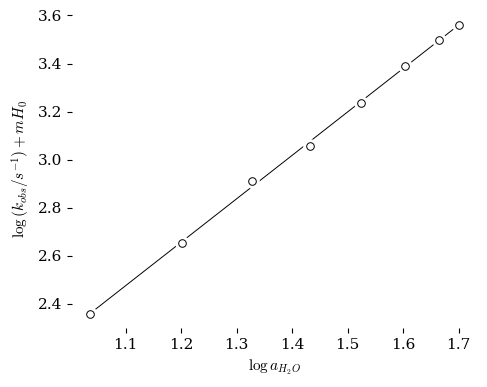

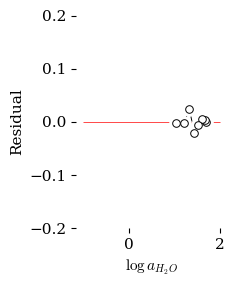

In [133]:
###################################################
### MAKE PLOT
###################################################

pKa = -5.9
Ka = 10**-pKa

h_0 = 10**-df1["H0"]

m = 0.68

###################################################
### Select the data for ESTER HYDROLYSIS
###################################################

#x = np.log10(df1["aH2O"])
#x = np.log10(df1["Molar_aH2O"])
x = np.log10(df1["Molar_aH2O"])

#y = df1["log_k_obs"]
y = df1["log_k_obs"]-np.log10(h_0**m/(Ka**m + h_0**m))
#y = df1["log_k_obs"] + m * df1["H0"]


###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

#x_label = "$\%wt {H_2SO_4}$"
x_label = "$\log{a_{H_2O}}$"

y_label = "$\log{(k_{obs} / {s}^{-1})} + mH_0$"

###################################################
### RATE vs ACIDITY Plot
###################################################

if True:                  # Set up axes for main plot
    ax.set(ylabel=y_label, xlabel=x_label,
#           xlim=[0,-5],
#           ylim=[0,-5]
           )

if True:                       # Data points for kobs vs Acidity
    ax.scatter(x, y, 
              marker = "o", s = 30, 
              color = "white", edgecolors = "black", linewidths=0.7, 
              zorder = 2)
    ax.scatter(x, y,           # White circle behind each data point 
              marker = "o", s = 90, 
              color = "white", 
              zorder = 1)


a = linregress(x,y)
print(a)
y_line = a.slope * x + a.intercept

ax.plot(x, y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 0)

plt.savefig("fig3.pdf")
plt.show()


###################################################
### Create figure for RESIDUAL plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  

###################################################
### Set up labels
###################################################

x_label = "$\log{a_{H_2O}}$"
y_label = "Residual"

###################################################
### Plot the residuals
###################################################

ax.set(ylabel=y_label, xlabel=x_label,
#           xlim=[0,-5],
           ylim=[-.2,.2]
        )

ax.plot(x, y-y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 0)

ax.scatter(x, y-y_line, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
ax.scatter(x, y-y_line,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 1)

#ax.hlines(0,np.min(x),np.max(x), color ="red", linewidths =0.5, zorder=0)
ax.hlines(0,-1,2, color ="red", linewidths =0.5, zorder=0)

plt.savefig("fig4r2.pdf")
plt.show()
